In [10]:
# import the necessary libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from urllib.parse import quote

In [11]:
# Datasets URL
url = "https://raw.githubusercontent.com/jishan96/OSSEN_Social_Networks/main/Data/"

In [12]:
# Adjacency matrices are available at both individual and household level. Here we perform the analysis on a household network
adj_path = '1_Network Data/Adjacency Matrices/adj_allVillageRelationships_HH_vilno_1.csv'
encoded_adj_path = quote(adj_path) # Construct the encoding path to the adjacency matrix for village 1
# Read in the adjacency matrix for village 1
df = pd.read_csv(url+encoded_adj_path, header=None)

In [13]:
# Change it into matrix form
adj_all_v1 = df.values
print(adj_all_v1)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


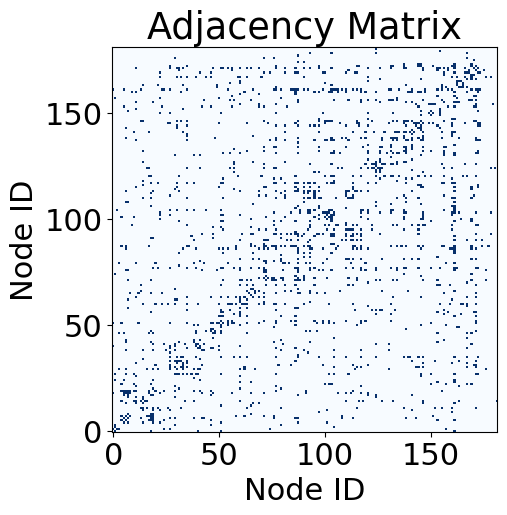

In [14]:
# We plot the adjacency matrix - Blue:connection and White:no connection
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 22})
plt.imshow(adj_all_v1, cmap='Blues', interpolation='none')
plt.gca().invert_yaxis()
plt.title('Adjacency Matrix')
plt.xlabel('Node ID')
plt.ylabel('Node ID')
plt.show()

In [15]:
# We generate the graph from the adjacency matrix
G = nx.from_numpy_array(adj_all_v1)
print(f"Number of nodes in G: {G.number_of_nodes()}")
print(f"Number of edges in G: {G.number_of_edges()}")

# Compute the average degree of nodes in the network


Number of nodes in G: 182
Number of edges in G: 868


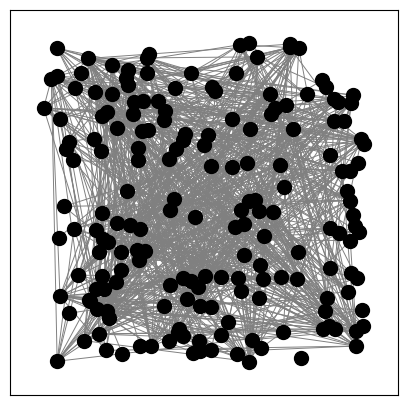

In [16]:
# Plot the graph for visualisation
plt.figure(figsize=(5, 5))
pos = nx.random_layout(G, seed=127) # We select random layout for nodes
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=100)
nx.draw_networkx_edges(
    G,
    pos,
    edge_color='gray',
    width=0.7
)

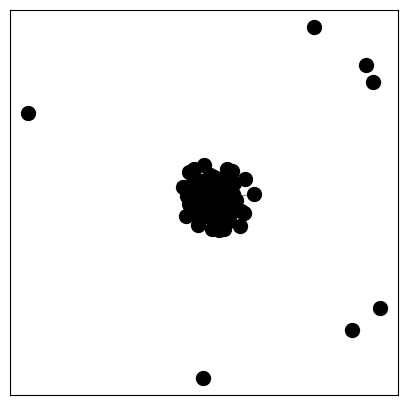

In [17]:
# Is there a better way to visualise the network?
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=100)
nx.draw_networkx_edges(
    G,
    pos,
    edge_color='gray',
    width=0.7
)

In [18]:
# We take the biggest connected component of the network for analysis
G_giant = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Relabel nodes in the Giant component from 1 to N, where N is the number of nodes in the giant component
node_labels_old = list(G_giant.nodes())
node_labels_new = list(range(0, len(node_labels_old) + 1))

node_label_map = dict(zip(node_labels_old, node_labels_new))

G_final = nx.relabel_nodes(G_giant, node_label_map)

# We save the node mapping
node_labels_df = pd.DataFrame({
    'original_node_label': node_labels_old,
    'new_node_label': [node_label_map[old_label] for old_label in node_labels_old]
})
node_labels_df

,original_node_label,new_node_label
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
170,177,170
171,178,171
172,179,172
173,180,173


In [19]:
# Print the no of nodes, edges and the average degree in the giant component. Has the average degree changed?


In [20]:
# Now plot the giant component using force layout


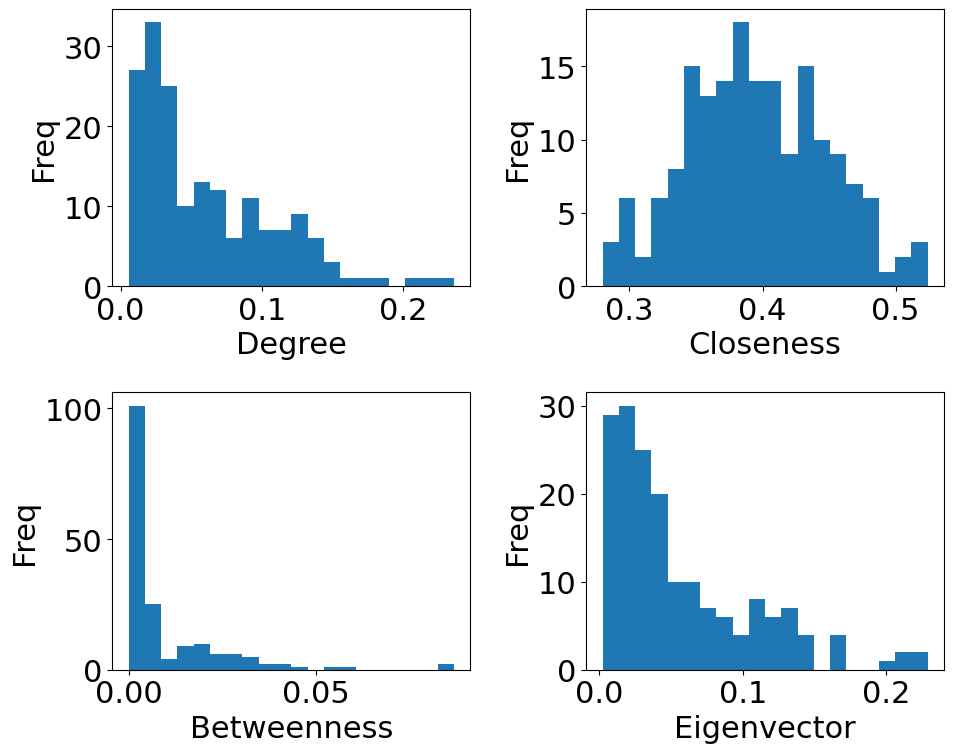

In [21]:
# We now compute the centrality metrics for nodes in the giant component

# Degree centrality measures the number of connections a node has in the network.
# It reflects how many immediate neighbours a node is connected to.
degree_centrality = nx.degree_centrality(G_final)

# Closeness Centrality measures how close a node is to all other nodes in the network.
# It is defined as the reciprocal of the average shortest path length from a node to all others,
# indicating how quickly a node can reach others.
closeness_centrality = nx.closeness_centrality(G_final)

# Betweenness Centrality measures the extent to which a node lies on paths between other nodes.
# Nodes with high betweenness can act as bridges or bottlenecks in the network.
betweenness_centrality = nx.betweenness_centrality(G_final)

# Eigenvector Centrality assigns relative scores to all nodes based on the principle that connections
# to high-scoring nodes contribute more to the score of the node.
eigenvector_centrality = nx.eigenvector_centrality(G_final)

centralities = {
    "Degree": degree_centrality,
    "Closeness": closeness_centrality,
    "Betweenness": betweenness_centrality,
    "Eigenvector": eigenvector_centrality
}

# We plot the distribution of the centralities
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

#
for i, (title, data) in enumerate(centralities.items()):
    axs[i].hist(list(data.values()), bins=20)
    axs[i].set_xlabel(f"{title}")
    axs[i].set_ylabel("Freq")
    axs[i].grid(False)

plt.tight_layout()
plt.show()

In [22]:
# We store the centralities in a dataframe
centrality_df = pd.merge(pd.DataFrame({
    'node': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    'eigenvector_centrality': list(eigenvector_centrality.values()),
}),node_labels_df, left_on = 'node', right_on = 'new_node_label').drop(columns = ['new_node_label'])
print(centrality_df.sort_values(by='degree_centrality', ascending=False).reset_index(drop = True).head(5))

   node  degree_centrality  closeness_centrality  betweenness_centrality  \
0   154           0.235632              0.524096                0.082735   
1    83           0.212644              0.510264                0.086828   
2   164           0.201149              0.516320                0.055488   
3    73           0.178161              0.519403                0.041125   
4    57           0.172414              0.487395                0.060399   

   eigenvector_centrality  original_node_label  
0                0.228827                  161  
1                0.209066                   87  
2                0.217236                  171  
3                0.221677                   77  
4                0.137323                   60  


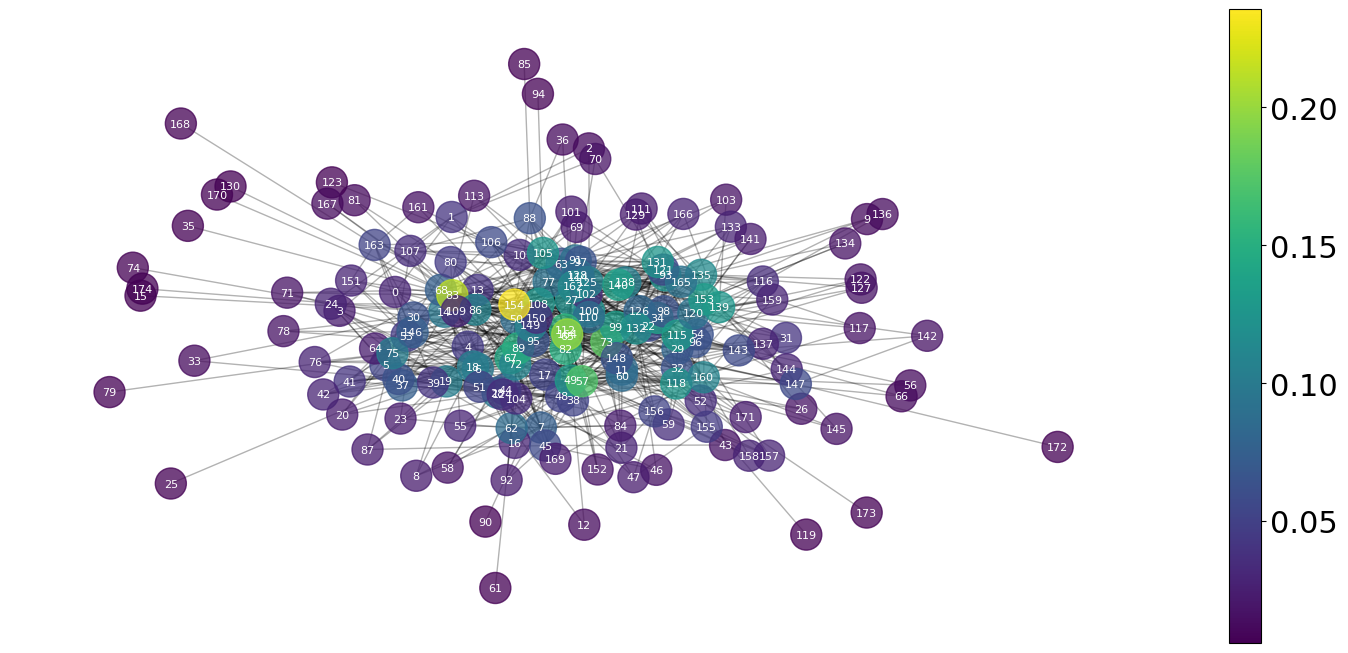

In [23]:
# Plot the network again and colour nodes based on their degree centrality
node_color = [degree_centrality[node] for node in G_final.nodes()]

pos = nx.spring_layout(
    G_final,
    seed=7,
    k=0.01,
    iterations = 100
)

fig, ax = plt.subplots(figsize=(15, 7))
plt.rcParams.update({'font.size': 22})
nodes = nx.draw_networkx_nodes(
    G_final, pos,
    node_color=node_color,
    cmap=plt.cm.viridis,
    node_size=500,
    alpha = 0.75,
    ax=ax
)
nx.draw_networkx_edges(G_final, pos, alpha=0.3, ax=ax)
nx.draw_networkx_labels(G_final, pos, font_size=8, font_color='white')

sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color))
)

cbar = fig.colorbar(sm, ax=ax)
ax.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# Sort nodes based on closeness centrality and print the top 5 nodes


In [25]:
# Plot the network again and colour nodes based on their closeness centrality - does it look different?


Error in village 13: HTTP Error 404: Not Found
Error in village 22: HTTP Error 404: Not Found


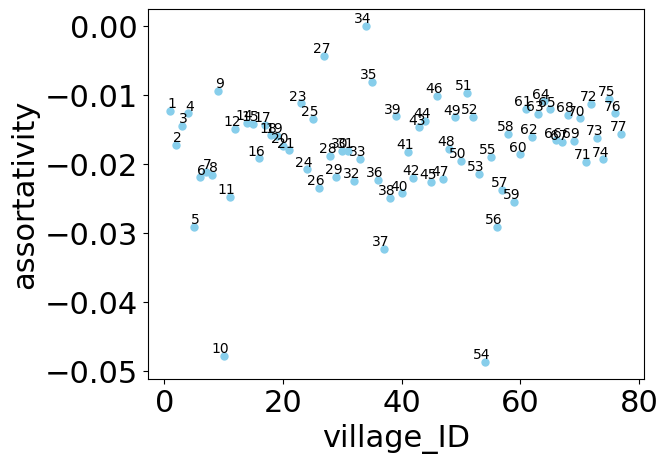

In [26]:
# For all 75 villages compute the degree assortativity of the network
# Assortativity in a network tells us if there is any preferential attachment in the network.
# For details see : https://arxiv.org/pdf/cond-mat/0209450
assortativity_village_list = []

for vilno in range(1, 78):  # Villages are numbered from 1 to 77 (Village 13 and 22 are missing)
    try:
        # Load adjacency matrix
        file_path = f"1_Network Data/Adjacency Matrices/adj_allVillageRelationships_HH_vilno_{vilno}.csv"
        encoded_file_path = quote(file_path)
        adj_df = pd.read_csv(url+encoded_file_path, header=None)
        adj_matrix = adj_df.values

        # Build networks - get the largest connected component
        G_copy = G.subgraph(max(nx.connected_components(nx.from_numpy_array(adj_matrix)), key=len)).copy()

        # Compute the assortative mixing based on node degrees
        degrees = {node: degree
             for node, degree
             in G_copy.degree}
        nx.set_node_attributes(G_copy, values=degrees, name='degree')
        # Compute assortative mixing based on node degrees
        assortativity = nx.attribute_assortativity_coefficient(G_copy,'degree')
        assortativity_village_list.append(
            pd.DataFrame({"village_ID": [vilno], "assortativity": [assortativity]})
            )
    except Exception as e:
        print(f"Error in village {vilno}: {e}")
        continue

    # Combine results
assortativity_df = pd.concat(assortativity_village_list, ignore_index=True)

# Plot the assortitative coefficient of all the villages
plt.rcParams.update({'font.size': 22})
assortativity_df.plot(
    kind='scatter',
    x='village_ID',
    y='assortativity',
    color='skyblue',
    s=25
)

for i, row in assortativity_df.iterrows():
    plt.text(row['village_ID']+1, row['assortativity']+0.0001, str(round(row['village_ID'])),
             fontsize=10, ha='right', va='bottom')

In [27]:
# Now we add characteristics of households to the centrality dataframe
# First read in the demographics data
demographics_path = "2_Demographics and Outcomes/household_characteristics.dta"
encoded_demographics_path = quote(demographics_path)
demographics_df = pd.read_stata(url+encoded_demographics_path)
# Filter for village 1
demographics_v1 = demographics_df[demographics_df['village']==1].copy()
demographics_v1

,village,adjmatrix_key,HHnum_in_village,hhid,hohreligion,castesubcaste,rooftype1,rooftype2,rooftype3,rooftype4,rooftype5,rooftypeoth,room_no,bed_no,electricity,latrine,ownrent,hhSurveyed,leader
0,1,1,1,1001,HINDUISM,,0,1,0,0,0,,3,4,No,None,OWNED,0,0
1,1,2,2,1002,HINDUISM,,0,1,0,0,0,,1,1,"Yes, Government",None,OWNED,1,1
2,1,3,3,1003,HINDUISM,,0,0,0,0,1,,3,4,"Yes, Private",None,OWNED,0,1
3,1,4,4,1004,HINDUISM,,0,1,0,0,0,,2,6,"Yes, Private",Owned,OWNED,0,0
4,1,5,5,1005,HINDUISM,,0,1,0,0,0,,3,4,"Yes, Private",None,OWNED,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,1,178,179,1179,HINDUISM,,0,1,0,0,0,,1,0,"Yes, Government",None,OWNED,0,1
178,1,179,180,1180,HINDUISM,,0,0,1,0,0,,2,1,"Yes, Private",Owned,OWNED,0,0
179,1,180,181,1181,HINDUISM,,0,0,0,1,0,,3,2,"Yes, Private",None,OWNED,0,0
180,1,181,182,1182,HINDUISM,,0,1,0,0,0,,2,0,"Yes, Private",None,OWNED,0,0


In [28]:
# Join demographics data with the centrality dataframe
# We have to match the node IDs
demographics_v1['adjusted_key'] = demographics_v1['adjmatrix_key'] - 1
node_centrality_and_demographics = pd.merge(
    centrality_df,
    demographics_v1,
    left_on='original_node_label', right_on='adjusted_key', how='left'
)
node_centrality_and_demographics

,node,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,original_node_label,village,adjmatrix_key,HHnum_in_village,hhid,...,rooftype5,rooftypeoth,room_no,bed_no,electricity,latrine,ownrent,hhSurveyed,leader,adjusted_key
0,0,0.028736,0.388393,0.002213,0.026865,0,1,1,1,1001,...,0,,3,4,No,None,OWNED,0,0,0
1,1,0.040230,0.343874,0.003521,0.012733,1,1,2,2,1002,...,0,,1,1,"Yes, Government",None,OWNED,1,1,1
2,2,0.011494,0.322820,0.000300,0.008441,2,1,3,3,1003,...,1,,3,4,"Yes, Private",None,OWNED,0,1,2
3,3,0.022989,0.352227,0.001462,0.010586,3,1,4,4,1004,...,0,,2,6,"Yes, Private",Owned,OWNED,0,0,3
4,4,0.045977,0.406542,0.005025,0.036936,4,1,5,5,1005,...,0,,3,4,"Yes, Private",None,OWNED,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,170,0.005747,0.338521,0.000000,0.012329,177,1,178,179,1179,...,0,,1,0,"Yes, Government",None,OWNED,0,1,177
171,171,0.022989,0.379085,0.000434,0.028970,178,1,179,180,1180,...,0,,2,1,"Yes, Private",Owned,OWNED,0,0,178
172,172,0.005747,0.287129,0.000000,0.002773,179,1,180,181,1181,...,0,,3,2,"Yes, Private",None,OWNED,0,0,179
173,173,0.005747,0.309059,0.000000,0.005966,180,1,181,182,1182,...,0,,2,0,"Yes, Private",None,OWNED,0,0,180


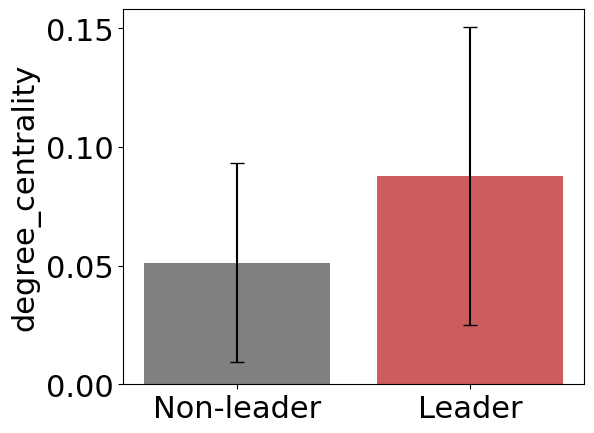

In [29]:
# Get the average degree centrality of leaders and non-leaders
grp_col = 'degree_centrality'
group_by_leader_status = node_centrality_and_demographics.groupby('leader')[grp_col].agg(['mean', 'std']).reset_index()

plt.rcParams.update({'font.size': 22})
plt.bar(
    group_by_leader_status['leader'],
    group_by_leader_status['mean'],
    yerr=group_by_leader_status['std'],
    capsize=5,
    color=['grey', 'indianred'],
    tick_label=['Non-leader', 'Leader']
)

plt.xticks([0, 1])
plt.ylabel(grp_col)
plt.tight_layout()
plt.show()

In [30]:
# Compute the average closeness centrality of leaders and non-leaders


In [31]:
# Define diffusion model  -  add a toy example in the slides - match to code block
# Explain the parameters in comment block above
def run_simulation(G_final,N,T,qN,qP,pC,seed_nodes,beta,seed=42):

    # Initialise the node sets
    np.random.seed(seed)
    informed_nodes = np.zeros(N)
    participant_nodes = np.zeros(N)

    # 0 - uninformed node, 1 - informed node
    informed_nodes[seed_nodes] = 1

    # We extract the informed node set. We do this because each node has only one shot at adopting microfinance
    newly_informed_nodes_list = seed_nodes

    infection_rate = []

    for t in range(1,T):

        participant_node_list = []

        # Adoption process
        for newly_informed_node in newly_informed_nodes_list:
            neighbours = list(G_final.neighbors(newly_informed_node))

            # We transform node characteristics and neighbour effects into probability of adoption using a logistic function
            if np.random.rand() <= 1/(1 + np.exp (-(beta[0]+ beta[1]*pC[newly_informed_node] + beta[2]*sum(participant_nodes[neighbours])))):
                participant_node_list.append(newly_informed_node)

        participant_nodes[participant_node_list] = 1

        infection_rate.append(sum(participant_nodes)/N)

        informed_nodes[newly_informed_nodes_list] = 1
        informed_nodes_list = np.where(informed_nodes == 1)[0]

        newly_informed_nodes_list = []

        # Transmission process
        for informed_node in informed_nodes_list:

            if (participant_nodes[informed_node] == 1 and np.random.rand() <= qP) or (participant_nodes[informed_node] == 0 and np.random.rand() <= qN) :
                # If the node is not already informed, it gets added to the newly informed list
                newly_informed_nodes_list.extend([
                    n for n in G_final.neighbors(informed_node)
                    if informed_nodes[n] == 0])

    return infection_rate,informed_nodes,participant_nodes

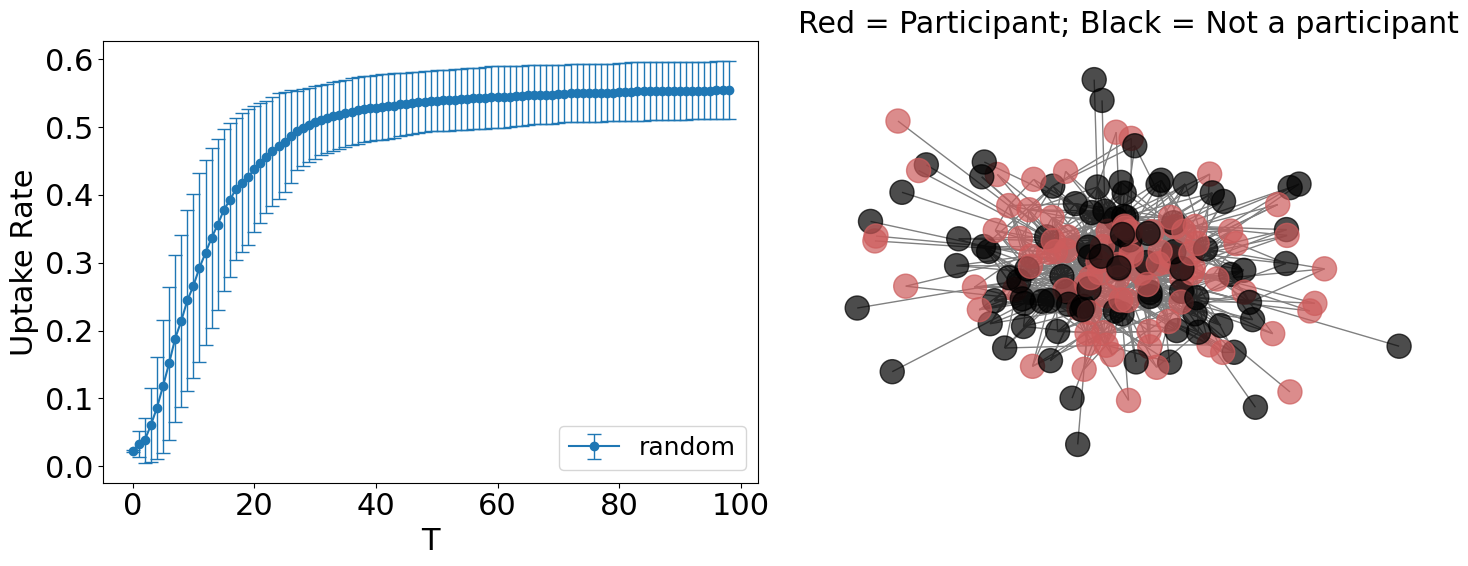

In [32]:
np.random.seed(12)
N = G_final.number_of_nodes()  # number of individuals
T = 100
qN = 0.01  # probability that a non-taker transmits info
qP = 0.05  # probability that a taker transmits info
pC = np.random.randint(0, 2, size=N) # randomly generate household characteristics
f= 0.05
beta = np.array([0, 0, 0.1])

infection_rate_random = []
for i in range(100):
    random_seed = np.random.randint(0, N, round(f * N))
    infection_rate_rand, informed_nodes_rand, participant_nodes_rand = run_simulation(G_final,N,T,qN,qP,pC,random_seed,beta)

    infection_rate_random.append(infection_rate_rand)

mean_infection_rate_random = np.mean(np.array(infection_rate_random), axis=0)
std_infection_rate_random = np.std(np.array(infection_rate_random), axis=0)



fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plt.rcParams.update({'font.size': 18})
node_colors = ['indianred' if participant_nodes_rand[i] == 1 else 'black' for i in range(N)]
pos = nx.spring_layout(G_final, seed=7, k=0.01, iterations=100)

#  Plot the rate of uptake in the network
axes[0].errorbar(
    np.arange(len(mean_infection_rate_random)),
    mean_infection_rate_random,
    yerr=std_infection_rate_random,
    fmt='-o',
    capsize=5,
    label='random',
    elinewidth=1
)

axes[0].set_xlabel('T')
axes[0].set_ylabel('Uptake Rate')
axes[0].legend()

# Plot the final state of the network
nx.draw_networkx_nodes(G_final, pos, node_color=node_colors, node_size=300, alpha=0.7, ax=axes[1])
nx.draw_networkx_edges(G_final, pos, edge_color='gray', ax=axes[1])
axes[1].set_title("Red = Participant; Black = Not a participant")
axes[1].axis('off')

plt.tight_layout()
plt.show()